<center> <h3> Final Project | ANLY-580 </h3>
<h4>  Georgetown University | Fall 2018</h4>
<center>

Test how well models trained on Wine Enthusiast Data transfer to winecellarinsider.com data

### Prep

In [19]:
import os
import sys
project_root = '/Users/kgedney/Documents/georgetown/anly580/anly580-wine-project'
os.chdir(project_root)

In [20]:
# install packages
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [21]:
# load scraped data from wine cellar to be the test set
df_full = pd.read_csv('data/cellarinsider_raw.csv', encoding='utf8')

In [22]:
df_full.columns
del df_full['Unnamed: 0']

### Prep Classes

In [23]:
# these are the 28 classes that it is trained on:

# {0: 'Barbera',
#  1: 'Bordeaux-style Red Blend',
#  2: 'Bordeaux-style White Blend',
#  3: 'Cabernet Franc',
#  4: 'Cabernet Sauvignon',
#  5: 'Champagne Blend',
#  6: 'Chardonnay',
#  7: 'Corvina, Rondinella, Molinara',
#  8: 'Grüner Veltliner',
#  9: 'Malbec',
#  10: 'Merlot',
#  11: 'Nebbiolo',
#  12: 'Pinot Grigio',
#  13: 'Pinot Gris',
#  14: 'Pinot Noir',
#  15: 'Port',
#  16: 'Portuguese Red',
#  17: 'Rhône-style Red Blend',
#  18: 'Riesling',
#  19: 'Rosé',
#  20: 'Sangiovese',
#  21: 'Sangiovese Grosso',
#  22: 'Sauvignon Blanc',
#  23: 'Shiraz',
#  24: 'Syrah',
#  25: 'Tempranillo',
#  26: 'Viognier',
#  27: 'Zinfandel'}

In [108]:
df_full['is_pinot_noir']         = df_full.bottle.apply(lambda x: 'pinot noir' in x.lower())
df_full['is_cabernet_sauvignon'] = df_full.bottle.apply(lambda x: 'cabernet sauvignon' in x.lower())
df_full['is_chardonnay']         = df_full.bottle.apply(lambda x: 'chardonnay' in x.lower())
df_full['is_cabernet_franc']     = df_full.bottle.apply(lambda x: 'cabernet franc' in x.lower())

In [109]:
print(df_full.is_pinot_noir.sum())
print(df_full.is_cabernet_sauvignon.sum())
print(df_full.is_chardonnay.sum())
print(df_full.is_cabernet_franc.sum())

49
933
162
20


In [110]:
df_full['variety_code'] = None

In [111]:
df_full['variety_code'].loc[df_full.is_cabernet_franc == True] = 3
df_full['variety_code'].loc[df_full.is_cabernet_sauvignon == True] = 4
df_full['variety_code'].loc[df_full.is_chardonnay == True] = 6
df_full['variety_code'].loc[df_full.is_pinot_noir == True] = 14

/Users/kgedney/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [112]:
df = df_full[~df_full.variety_code.isna()].reset_index(drop=True)

In [113]:
df.variety_code.value_counts()

4     933
6     162
14     49
3      20
Name: variety_code, dtype: int64

#### Run Baseline SVM

In [114]:
# set classes
x = df.note.values
y = df.variety_code.values

In [115]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=522)

In [116]:
# majority class prediction
np.mean(y_test == 4)

0.8025751072961373

In [117]:
# data preprocess
tfidf_vec   = TfidfVectorizer()
x_train_vec = tfidf_vec.fit_transform(x_train)
x_test_vec  = tfidf_vec.transform(x_test)
x_train_vec.shape, x_test_vec.shape

/Users/kgedney/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


((931, 2330), (233, 2330))

In [118]:
# remap 
y_train_lookup = dict(zip(np.unique(y_train), range(len(np.unique(y_train)))))
y_train_remap  = [y_train_lookup[yy] for yy in y_train]
y_test_remap   = [y_train_lookup[yy] for yy in y_test]

In [119]:
# fit model
from sklearn.svm import LinearSVC
clf             = LinearSVC().fit(x_train_vec, y_train_remap)
predicted       = clf.predict(x_test_vec)
predicted_score = clf.decision_function(x_test_vec)
print('accuracy', metrics.accuracy_score(y_test_remap, predicted))

accuracy 0.9484978540772532


In [122]:
df.shape

(1164, 13)

### Keras Model

#### Import model

In [123]:
import keras
from keras import optimizers
import tensorflow as tf

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.models import Model, Sequential
from keras.layers import Input, Dense, CuDNNLSTM, LSTM, Embedding, Bidirectional, GlobalAveragePooling1D, Conv1D, Activation, Flatten, Dropout, MaxPooling1D, Embedding, GlobalMaxPooling1D

from keras.layers.core import Dense, Dropout

import pickle

In [124]:
model1 = keras.models.load_model('wine_model_l.h5')
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))

#### Prep Data for Keras

In [125]:
# data preprocess
x = df.note.values
y = df.variety_code.values

# create sequences
# max_features = 25000
# tokenizer    = Tokenizer(num_words = max_features)
# tokenizer.fit_on_texts(x)
x_sequences  = tokenizer.texts_to_sequences(x)

# pad each sequence to be max length
maxlen = 136
x_sequences = sequence.pad_sequences(x_sequences, maxlen)

#### Run Results

In [126]:
print('accuracy', model1.evaluate(x_sequences, y)[1])

1164/1164 [==============================] - 0s 106us/step
accuracy 0.40034364261168387


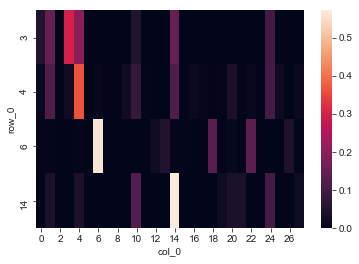

In [127]:
import seaborn as sns
from matplotlib import pyplot as plt

preds = model1.predict(x_sequences)
to_plot = pd.crosstab(y, preds.argmax(axis=-1), normalize='index')
sns.heatmap(to_plot)
plt.show()

In [128]:
to_plot.T

row_0,3,4,6,14
col_0,,,,
0,0.05,0.012862,0.006173,0.000000
1,0.15,0.117899,0.006173,0.040816
2,0.00,0.001072,0.000000,0.000000
3,0.30,0.023580,0.000000,0.000000
4,0.20,0.365488,0.006173,0.040816
5,0.00,0.001072,0.000000,0.000000
6,0.00,0.009646,0.561728,0.000000
7,0.00,0.003215,0.000000,0.000000
8,0.00,0.001072,0.000000,0.000000


In [129]:
df[['note', 'bottle']].head().values

array([['Lemons, pears and green apples define this wine. There is freshness and sweet fruits on the backend and a pleasant touch of stone from start to finish. The wine has early drinking appeal.',
        'Hubert de Boüard Le Chardonnay\xa0 (Vin de France)'],
       ['Honeyed grapefruit, with hints of tropical fruit, the wine is fresh, if not peppy, there is enough volume and length to make this a fun, early drinking, summer wine.',
        'Hubert de Boüard Le Chardonnay\xa0 (Vin de France)'],
       ['Medium bodied with ripe, sweet cherries, underbrush and licorice, the wine is delectable and fresh. Drink this ten to 12 years after the vintage.',
        'Château Mangot Cabernet Sauvignon Todeschini\xa0 (St. Émilion Grand Cru)'],
       ['Smoke, licorice and tobacco rise above the dark red fruits in this deeply colored wine. Polished and fresh with a concentrated dark plum center and silky tannins, the wine is produced from a parcel selection of their best four hectares of vines.',